# Neural and Universal Ordinary Differential Equations: Part 01
Following along from notes by [Chris Rackauckas](https://mitmath.github.io/18S096SciML/lecture3/diffeq_ml).

We can relate neural networks to differential equations through the *neural differential equations*. To begin, consider the recurrent neural network:

$$x_{n+1} = x_n + \text{NN}(x_n).$$

In general, we can consider pulling out a multiplication factor $h$, such that $t_{n+1} = t_n + h$, and

$$x_{n+1} = x_n + h \cdot\text{NN}(x_n),$$

$$\frac{x_{n+1} - x_n}{h} = \text{NN}(x_n),$$

allowing us to rewrite the limit $h \rightarrow 0$

$$x^\prime = \text{NN}(x_n).$$

## Training ODEs
Rackauckas has written exstensive notes on [training neural ODEs](https://mitmath.github.io/18337/lecture11/adjoints), which I will summarize in my own words here (todo). 

For simplicity, we will not concern ourselves with the details here, and instead use the default gradient calculation in `DiffEqFlux.jl`.

We will use the [`Flux.jl`](https://github.com/FluxML/Flux.jl) neural network library. Let us fist define a problem, namely the [Lotka-Volterra system](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations):

In [1]:
using OrdinaryDiffEq, Plots, Flux, DiffEqFlux

In [2]:
function lotka_volterra!(du, u, p, t)
    x, y = u
    α, β, δ, γ = p
    du[1] = α * x - β * x * y
    du[2] = - δ * y + γ * x * y
end

lotka_volterra! (generic function with 1 method)

Next, we solve this using a traditional ODEProblem approach:

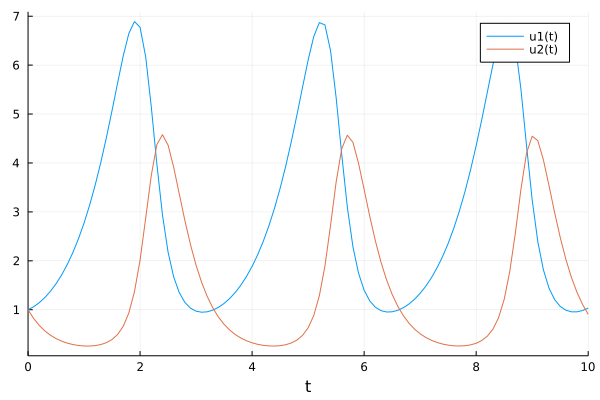

In [3]:
u0 = [1.0, 1.0]
tspan = (0.0, 10.0)

p = [1.5, 1.0, 3.0, 1.0]

prob = ODEProblem(lotka_volterra!, u0, tspan, p)
sol = solve(prob, Tsit5(), saveat=0.1)

plot(sol)

### Building a neural network

Next, we define a *single layer* NN, that uses `concrete_solve` to return a $x(t)$ solution. The method `concrete_solve` is built on `DifferentialEquations.jl`'s `solve` method, which uses a backpropagation algorithm to determine the gradient:

In [4]:
test_data = Array(sol)
p2 = [2.2, 1.0, 2.0, 0.4] # inital parameter vector

function predict_adjoint() # single layer neural network
    Array(
        concrete_solve(
            prob, 
            Tsit5(), 
            u0,
            p2,
            saveat=0.1, 
            abstol=1e-6,
            reltol=1e-5
        )
    )
end

predict_adjoint (generic function with 1 method)

Next we specify a loss function through which we can evaluate the model. Our aim is to ensure the Lotka-Volterra solution is a constant $x(t)=1$, so will define the loss as the distance from 1:

In [5]:
loss_adjoint() = sum(abs2, predict_adjoint() - test_data)

loss_adjoint (generic function with 1 method)

### Training the network
We will use ADAM optimization, with a callback to observe the training steps:

In [6]:
training_plots = []
iter = 0

function callback()
    global iter += 1
    if iter % 50 == 0
        @show loss_adjoint()

        # use remake to reconstruct problem with updated parameters
        pl = plot(
            solve(
                remake(
                    prob,
                    p=p2
                ),
                Tsit5(),
                saveat=0.0:0.1:10.0
            ),
            ylim=(0,8)
        )

        Plots.scatter!(
            pl, 
            0.0:0.1:10,
            test_data',
            markersize=2
        )

        push!(training_plots, pl)
    end
end

# ode with initial parameter values
callback()

data = Iterators.repeated((), 300) # 300 training cycles

# configure optimizer
opt = ADAM(0.1)

# train model
Flux.train!(loss_adjoint, Flux.params(p2), data, opt, cb=callback)
"Done"

loss_adjoint() = 32.34829777599752
loss_adjoint() = 11.629225315092674
loss_adjoint() = 3.829282142889687
loss_adjoint() = 1.0191501351040286
loss_adjoint() = 0.2306485389739099
loss_adjoint() = 0.04615635014557406


"Done"

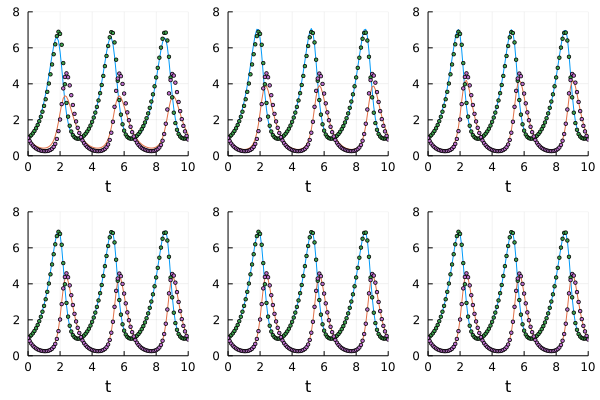

In [7]:
plot(training_plots...; legend=false)

We can continue along this line by using gradient descent to force a monotone functional convergence:

In [8]:
data = Iterators.repeated((), 300)

opt = Descent(0.00001)
Flux.train!(loss_adjoint, Flux.params(p), data, opt, cb=callback)
"Done"

loss_adjoint() = 0.04467175469870548
loss_adjoint() = 0.04467175469870548
loss_adjoint() = 0.04467175469870548
loss_adjoint() = 0.04467175469870548
loss_adjoint() = 0.04467175469870548
loss_adjoint() = 0.04467175469870548


"Done"

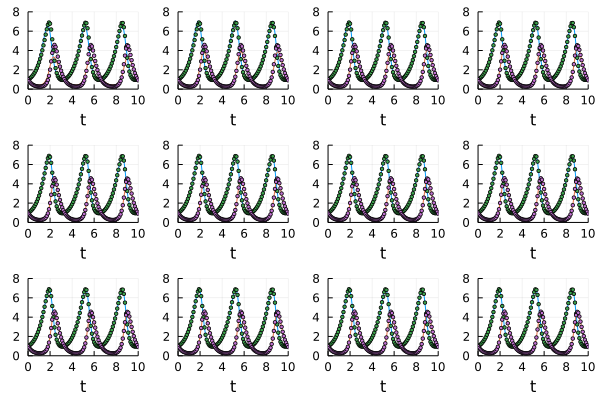

In [9]:
plot(training_plots...; legend=false)